In [1]:
import cv2
import numpy as np
import requests
from itertools import product
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

# HW3: Multiple View Geometry

In the lst couple of weeks we've talked about multiple-view geometry. The main pursuits in this domain are:
* Reconstructing the 3D geometry of the objects in the visible scene
  * Dense reconstruction with stereo
  * Sparse reconstruction with feature key-points (e.g corners)
* Estimating the pose (location, orientation) of the cameras looking at the scene


We will work with images from a canonical Structure-from-Motion dataset: https://cvlab.epfl.ch/data/data-strechamvs/

Download images

In [2]:
DOWNLOAD_IDS = ['1a0t86-RWgbcaa2Lxoxtvst9h4Zmub-Jd','1r4pwRwta8FHTdXiUtmpWDDi43FdWPqGd','1i5e6v2ebiUeq-iCGQmgO2wcvAdMFcvEB']
images = [cv2.resize(cv2.imdecode(np.frombuffer(requests.get("https://drive.google.com/uc?id=%s"%(dl_id)).content, np.uint8), cv2.IMREAD_COLOR)[...,::-1],(0,0),fx=0.25,fy=0.25) for dl_id in DOWNLOAD_IDS]

In [3]:
HEIGHT,WIDTH,_=images[0].shape

In [4]:
orb = cv2.ORB_create(2000)
matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING, True)

A helper function to match features and filter the matching with a RANSAC process to find a fundamental matrix

In [5]:
def getMatchesWithFilter(i,j,kpts_,desc_,matcher_):
    matches_ = matcher_.match(desc_[i],desc_[j])
    mptsi,mptsj = zip(*[(kpts_[i][m.queryIdx].pt,kpts_[j][m.trainIdx].pt) for m in matches_])
    _, mask_ = cv2.findFundamentalMat(np.array(mptsi), np.array(mptsj), cv2.RANSAC, ransacReprojThreshold=3)
    inliers = [m for k,m in enumerate(matches_) if mask_[k] == 1]
    mptsif,mptsjf = zip(*[(kpts_[i][m.queryIdx].pt,kpts_[j][m.trainIdx].pt) for m in inliers])
    return np.array(mptsif),np.array(mptsjf),inliers

### Find features in all images

In [6]:
kpts, descs = zip(*[orb.detectAndCompute(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), None) for img in images])

We can match two keypoint sets:

In [7]:
mpts01f,mpts10f,matches01 = getMatchesWithFilter(0,1,kpts,descs,matcher)
indices01,indices10 = zip(*[(m.queryIdx,m.trainIdx) for m in matches01])
mpts02f,mpts20f,matches02 = getMatchesWithFilter(0,2,kpts,descs,matcher)
indices02,indices20 = zip(*[(m.queryIdx,m.trainIdx) for m in matches02])
mpts12f,mpts21f,matches12 = getMatchesWithFilter(1,2,kpts,descs,matcher)
indices12,indices21 = zip(*[(m.queryIdx,m.trainIdx) for m in matches12])

For example:

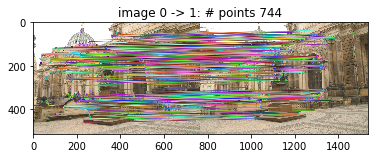

In [8]:
plt.imshow(cv2.drawMatches(images[0],kpts[0],images[1],kpts[1],matches01,None))
plt.title('image 0 -> 1: # points %d'%(len(matches01)));

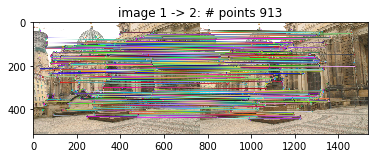

In [9]:
plt.imshow(cv2.drawMatches(images[1],kpts[1],images[2],kpts[2],matches12,None))
plt.title('image 1 -> 2: # points %d'%(len(matches12)));

## 1. Two-frame Structure-from-Motion

1. Estimate essential matrix (with re-scaling)
1. Decompose to find $[R|t]$
1. Triangulate sparse 3D point cloud
1. Rectify to get parallel-motion
1. Dense stereo

### Estimate the essential matrix - the linear method

The epipolar constraint: $x_\mathrm{R}^\top E x_\mathrm{L} = 0$ leads to the following $Ab=0$ system of equations:
$$
\begin{pmatrix}x_R & y_R & 1 \end{pmatrix}\begin{bmatrix}e_{00} & e_{01} & e_{02} \\ e_{10} & e_{11} & e_{12} \\ e_{20} & e_{21} & e_{22}\end{bmatrix}\begin{pmatrix}x_L\\y_L\\1 \end{pmatrix} = 0
\\
\begin{pmatrix}
x_Re_{00} + y_Re_{01} + e_{02} &
x_Re_{10} + y_Re_{11} + e_{12} &
x_Re_{20} + y_Re_{21} + e_{22} 
\end{pmatrix}
\begin{pmatrix}x_L\\y_L\\1 \end{pmatrix} = 0
\\
x_Lx_Re_{00} + x_Ly_Re_{01} + x_Le_{02} + 
y_Lx_Re_{10} + y_Ly_Re_{11} + y_Le_{12} +
x_Re_{20} + y_Re_{21} + e_{22} 
= 0
\\
\begin{pmatrix}
\cdots \\
x_Lx_R & x_Ly_R & x_L &
y_Lx_R & y_Ly_R & y_L &
x_R & y_R & 1 \\
\cdots \\
\end{pmatrix}
\begin{pmatrix}
e_{00} \\ e_{01} \\ e_{02} \\ e_{10} \\ e_{11} \\ e_{12} \\ e_{20} \\ e_{21} \\ e_{22} \\
\end{pmatrix}=0
$$
(where every row of A is essentially $x_\mathrm{L}x_\mathrm{R}^\top$ ($3\times3$) flattened, e.g. `(xL * xR.T).ravel()`)

However, remember we talked about the scaling problem, where $x*x$ is orders of magnitude larger than $x$ and $1$, therefore we should normalize the points to the $[-1,1]$ range before solving. Afterwards we can apply the inverse scaling to $E$ to negate this effect.

Populate the matrix $A$ and solve for $E$ in the least squares sense: $\hat{b} = \mathop{\arg\min}_b|Ab|^2$, which means taking the SVD (`np.linalg.svd`) and using the last row of $V^\top$, where the singular value is 0.

Assume a mock intrinsics matrix
$$
K = \begin{bmatrix}f_x & s & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1\end{bmatrix} = \begin{bmatrix}f & 0 & W/2 \\ 0 & f & H/2 \\ 0 & 0 & 1\end{bmatrix}
$$
where $f=300$, `W` and `H` are obtained above.

In [10]:
K = np.array([[300,0,WIDTH/2.],[0,300,HEIGHT/2],[0,0,1]])
Kinv = np.linalg.inv(K)

Transform the points to normalized coordinates

In [11]:
mpts01t,mpts10t = [np.matmul(Kinv,np.squeeze(cv2.convertPointsToHomogeneous(pts)).T).T for pts in [mpts01f,mpts10f]]

In [12]:
# Calculate the Essential Matrix according to the above equations
def calculateEssentialMatrix(ptsLeftHomog, ptsRightHomog):
    numPoints = ptsLeftHomog.shape[0]
    A=np.array([(ptsRightHomog[i,np.newaxis] * ptsLeftHomog[np.newaxis,i].T).ravel() for i in range(numPoints)])
    U,D,V = np.linalg.svd(A)
    E = V[-1].reshape(3,3)
    return E

Below is a "poor man's RANSAC", randomly selecting 9 point-pairs and calculating $E$ from them, then counting the supporting "inlier" points by checking how far they are from their corresponding epilines.

In [13]:
# Run this cell once you implemenetd the above function
maxv = 0
for i in range(5000):
    sample = np.random.randint(0,mpts01f.shape[0],(9,1))

    pts0smp = mpts01t[sample]
    pts1smp = mpts10t[sample]
    E_guess = calculateEssentialMatrix(pts0smp, pts1smp)
    
    # find inliers
    l0 = np.matmul(mpts10t, E_guess)
    ep = np.abs([np.matmul(l, mpts01t[i]) for i,l in enumerate(l0)])
    inliers = ep < 0.0001
    err = np.sum(ep)
    score = np.sum(inliers) / err
    if score > maxv:
        maxv = score
        print("# inliers: %d"%(np.sum(inliers)))
        
        # recalculate E with the inliers
        pts0smp = np.compress(inliers,mpts01t,axis=0)
        pts1smp = np.compress(inliers,mpts10t,axis=0)
        E = calculateEssentialMatrix(pts0smp, pts1smp)

# inliers: 4
# inliers: 5
# inliers: 4
# inliers: 4
# inliers: 6
# inliers: 11
# inliers: 10
# inliers: 10
# inliers: 10


Here's what it found: (it doesn't make much intuitive sense)

In [14]:
E

array([[ 0.00687601,  0.10664128,  0.26006722],
       [-0.12847907,  0.0283352 ,  0.65793439],
       [-0.26161767, -0.63426824,  0.00424043]])

### Decompose $E$ to $[R|t]$
Recall the essential matrix is composed: $E = [t]_\times R$.

The decomposition can be performed using SVD, e.g. $E = U\Sigma V^\top$, and set $t$ to be the last column of $\pm U$, while
$$
\begin{align}
W &= \begin{bmatrix}0 & -1 & 0 \\ 1 & 0 & 0 \\ 0 & 0 & 1\end{bmatrix}  \mathrm {,\,\,A\,\, 90^\circ\,\, rotation}\\
R_1 &= UWV^\top\\
R_2 &= UW^{-1}V^\top
\end{align}
$$
This results in **4 configurations**: $(t,R_1)$,$(t,R_2)$,$(-t,R_1)$,$(-t,R_2)$. See your readings for the reason.

To find the correct pair we should use the "cheirality check", which essentially means we triangulate 3D points and check they have positive Z coordinates and they are indeed in front of both cameras.

In [15]:
# TODO: Take SVD of E, e.g. `np.linalg.svd`
U,D,V = np.linalg.svd(E)
t = U[:, -1]

In [16]:
W = np.array([[0,-1,0],[1,0,0],[0,0,1]])
R1 = np.matmul(np.matmul(U, W), V)
R2 = np.matmul(np.matmul(U, W.T), V)

In [17]:
R1,R2,t

(array([[ 0.999301  , -0.02203959,  0.03019534],
        [ 0.0228346 ,  0.99939478, -0.02624211],
        [-0.0295987 ,  0.02691327,  0.99919948]]),
 array([[ 0.6724337 , -0.67183921,  0.31058814],
        [-0.67750204, -0.72766515, -0.10721199],
        [ 0.29803339, -0.13833115, -0.94447901]]),
 array([ 0.92090962, -0.36063709,  0.14787279]))

### Triangulate 3D points
Recall that by multipying both sides of the point projection equation on the left with $K^{-1}$ we get:

$$
\displaystyle
\begin{bmatrix}\lambda x'\\\lambda y'\\\lambda\end{bmatrix}
=
\begin{bmatrix}
r_1 & r_2 & r_3 & t_x\\
r_4 & r_5 & r_6 & t_y\\
r_7 & r_8 & r_9 & t_z\\
\end{bmatrix}
\begin{bmatrix}X\\Y\\Z\\W\end{bmatrix}
$$
Find $\lambda=r_7X+r_8Y+r_9Z+Wt_z$ and substitute back:
$$
\begin{bmatrix}
x'(r_7X+r_8Y+r_9Z+t_zW)\\
y'(r_7X+r_8Y+r_9Z+t_zW)
\end{bmatrix}
=
\begin{bmatrix}
r_1 & r_2 & r_3 & t_x\\
r_4 & r_5 & r_6 & t_y
\end{bmatrix}
\begin{bmatrix}X\\Y\\Z\\W\end{bmatrix}
$$
Rearrange some more:
$$
\displaystyle
\begin{bmatrix}
x'r_7 - r_1 & x'r_8 - r_2 & x'r_9 - r_3 & x't_z - t_x \\
y'r_7 - r_4 & y'r_8 - r_5 & y'r_9 - r_6 & y't_z - t_y  \\
\end{bmatrix}
\begin{bmatrix}
X\\Y\\Z\\W
\end{bmatrix}
= 
0
$$
Now if we have 2 contributions to this system we can solve this linear system of equations $Ab=0$ in the least squares sense (`np.linalg.svd`).

Write the triangulation routine

In [18]:
def triangulatePointsHomog(Xs, Rs, ts):
    out = []
    for i in range(Xs[0].shape[0]):
        A = np.zeros((len(Xs)*2,4),np.float32)

        for j in range(len(Xs)):
            r = Rs[j].ravel()
            t = ts[j]
            x,y,_ = Xs[j][i]
            
            A[2*j+0] = [x*r[6] - r[0], x*r[7] - r[1], x*r[8] - r[2], x*t[2] - t[0]]
            A[2*j+1] = [y*r[6] - r[3], y*r[7] - r[4], y*r[8] - r[5], y*t[2] - t[1]]

        U,D,V = np.linalg.svd(A)
        out.append(V[-1])
        # TODO: solve Ab=0 LLSQ, e.g. `np.linalg.svd`
        # TODO: out += [...] # take last row of vT

    return np.array(out)

Make a decision about the 4 possible configurations (e.g. $(t,R_1)$,$(t,R_2)$,$(-t,R_1)$,$(-t,R_2)$) using the following criteria:
1. Cheirality check: Count how many points are in front of the camera (positive +z coordinate)
1. Reprojection check: Distance between original 2D point and 3D point reprojected back to 2D

In [19]:
maxv = 0
R_best = t_best = None
for rot,tra in [(R1,t),(R1,-t),(R2,t),(R2,-t)]:
    # triangulate points
    pts4d = triangulatePointsHomog([mpts01t, mpts10t], [np.eye(3,3), rot], [[0,0,0], tra]).T
    # undo homogeneous coordinate
    pts3d = np.vstack([pts4d[0,:] / pts4d[3,:],pts4d[1,:] / pts4d[3,:],pts4d[2,:] / pts4d[3,:]]).T
    # reproject points back to image domain
    projPts2dRight,_ = cv2.projectPoints(pts3d, cv2.Rodrigues(rot)[0], tra, K, None)
    
    cheirality = np.sum(pts3d[:,2]>0)
    print("Cheirality: %d/%d"%(cheirality,pts3d.shape[0]))
    mse = np.mean(np.linalg.norm(np.squeeze(projPts2dRight) - mpts10f,axis=1))
    print("Reprojection err: %.3f"%(mse))
    score = cheirality / mse
    if score > maxv:
        maxv = score
        R_best = rot
        t_best = tra

Cheirality: 733/744
Reprojection err: 2.875
Cheirality: 11/744
Reprojection err: 2.875
Cheirality: 299/744
Reprojection err: 2.873
Cheirality: 445/744
Reprojection err: 2.873


The reprojection error above should be < 10. If that's not the case it's likely the $E$ matrix isn't right - try finding it again.

In [20]:
R_best, t_best

(array([[ 0.999301  , -0.02203959,  0.03019534],
        [ 0.0228346 ,  0.99939478, -0.02624211],
        [-0.0295987 ,  0.02691327,  0.99919948]]),
 array([ 0.92090962, -0.36063709,  0.14787279]))

In [21]:
# triangulate points
pts4d = triangulatePointsHomog([mpts01t, mpts10t], [np.eye(3,3), R_best], [[0,0,0], t_best]).T
# undo homogeneous coordinate
pts3d = np.vstack([pts4d[0,:] / pts4d[3,:],pts4d[1,:] / pts4d[3,:],pts4d[2,:] / pts4d[3,:]]).T

Show the points reprojected alongside the originals, any strong deviation here will suggest a bug

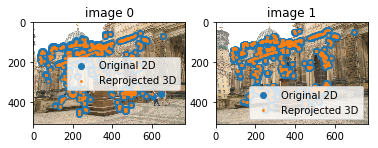

In [22]:
projPts2dLeft,_  = cv2.projectPoints(pts3d, (0,0,0), (0,0,0), K, None)
projPts2dRight,_ = cv2.projectPoints(pts3d, cv2.Rodrigues(R_best)[0], t_best, K, None)

for i,(points,originals) in enumerate([(projPts2dLeft,mpts01f), (projPts2dRight,mpts10f)]): 
    plt.subplot(1,2,i+1)
    plt.imshow(images[i])
    plt.scatter(originals[:,0],originals[:,1],label='Original 2D')
    plt.scatter(points[:,0,0],points[:,0,1],label='Reprojected 3D',s=3)
    plt.legend(),plt.title('image %d'%i);

---
## 2. Incremental SfM
Add another camera to your reconstructed scene: 
1. Find matching 2D-3D points
1. Find camera pose with linear pose estimation
1. Re-triangulate the 3D points with 3 cameras

### 2D-3D correspondences
To get 2D-3D correspondences we go back to the original matching (Image 1 $\leftrightarrow$ Image 2), and select the 2D points in Image 1 (which created 3D points with Image 0) intersected with 2D points in Image 2.

In [23]:
int1210     = np.intersect1d(indices12,indices10)
corresp12   = [(np.argwhere(np.array(indices10)==i)[0,0],np.argwhere(np.array(indices12)==i)[0,0]) for i in int1210]
mpts21t     = np.matmul(Kinv,np.squeeze(cv2.convertPointsToHomogeneous(mpts21f)).T).T
corresp2D3D = np.array([(pts3d[c[0]],mpts21t[c[1]]) for c in corresp12])

Make sure 2D-3D correspondences make sense

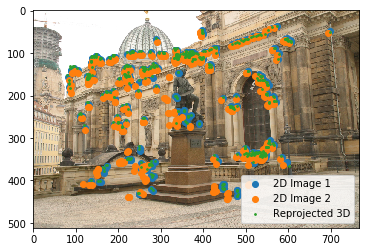

In [24]:
pts3dCorresp = np.array([c[0] for c in corresp2D3D])
projPts2d1,_ = cv2.projectPoints(pts3dCorresp, cv2.Rodrigues(R_best)[0], t_best, K, None)
pts2d12 = np.array([mpts12f[c[1]] for c in corresp12])
pts2d21 = np.array([mpts21f[c[1]] for c in corresp12])

plt.imshow(images[1])
plt.scatter(pts2d12[:,0],pts2d12[:,1],label='2D Image 1')
plt.scatter(pts2d21[:,0],pts2d21[:,1],label='2D Image 2')
plt.scatter(projPts2d1[:,0,0],projPts2d1[:,0,1],label='Reprojected 3D',s=3)
plt.legend();

### Camera pose - the linear method
Remember, as per usual we start from
$$
\lambda\begin{bmatrix}x\\y\\1\end{bmatrix}
=
\begin{bmatrix}f_x & 0 & c_x\\0 & f_y & c_y \\0 & 0 & 1\end{bmatrix}
\begin{bmatrix}
r_1 & r_2 & r_3 & t_x\\
r_4 & r_5 & r_6 & t_y\\
r_7 & r_8 & r_9 & t_z\\
\end{bmatrix}
\begin{bmatrix}X\\Y\\Z\\1\end{bmatrix}
$$
Multiply on left with $K^{-1}$ and rearrange (after finding $\lambda$):
$$
\displaystyle
\begin{bmatrix}
x'(r_7X+r_8Y+r_9Z+t_z)\\
y'(r_7X+r_8Y+r_9Z+t_z)
\end{bmatrix}
=
\begin{bmatrix}
r_1 & r_2 & r_3 & t_x\\
r_4 & r_5 & r_6 & t_y
\end{bmatrix}
\begin{bmatrix}X\\Y\\Z\\1\end{bmatrix}
$$
Which leads, with further rearrangement, to an $Ab=0$ homogeneous system of equations to find $R,t$:
$$
\begin{bmatrix}
\cdots \\
X_i & Y_i & Z_i & 1 & 0    & 0    & 0    & 0  & -x'_iX_i & -x'_iY_i & -x'_iZ_i & -x'_i  \\
0    & 0    & 0    & 0  & X_i & Y_i & Z_i & 1 & -y'_iX_i & -y'_iY_i & -y'_iZ_i & -y'_i \\
\cdots 
\end{bmatrix}
\begin{bmatrix}
r_1 \\ r_2 \\ r_3 \\ t_x \\ r_4 \\ r_5 \\ r_6 \\ t_y \\ r_7 \\ r_8 \\ r_9 \\ t_z
\end{bmatrix}
= 0
$$
Which we can solve by solving the "minimal direction problem" ($\hat{b} = \mathop{\arg\min}_b|Ab|^2 \,\,\,\,\, \mathrm{s.t.} \,\,\, |b|=1
$), which essentially means we take the SVD: $A=U\Sigma V^\top$, and take as the solution the last row of $V^\top$, and (according to this formulation) simply reshape it $3\times4$ to obtain P.

However, the calculated matrix $P$ can take on an arbitrary scale, so the $R_{3\times3}$ matrix may need some conditioning to become a true rotation (orthonormal), effectively removing the scaling factor. Therefore we take the SVD and omit the scaling matrix $\Sigma$:
$$
\begin{align}
R &= U\Sigma V^\top\\
\hat{R} &= UV^\top
\end{align}
$$
When we do that we need to impose the same rescaling on the translation: $\hat{t} = t\cdot\sum \hat{R}/R$

In [25]:
def calculateCameraPose(corresp2D3D_):
    A = np.zeros((2*len(corresp2D3D_),12))
    for i,(p3d,p2d) in enumerate(corresp2D3D_):
        x2,y2,_  = -p2d
        x3,y3,z3 = p3d
        
        A[2*i+0] = [x3, y3, z3, 1, 0, 0, 0, 0, x2*x3, x2*y3, x2*z3, x2]
        A[2*i+1] = [0, 0, 0, 0, x3, y3, z3, 1, y2*x3, y2*y3, y2*z3, y2]
        # TODO: populate the A matrix
        # e.g. A[2*i+0] = [...
        # e.g. A[2*i+1] = [...
        
    # TODO: take last row of vT as new P, reshape to (3,4)

    # TODO: take [:,:3] of P as R_new
    U,D,V = np.linalg.svd(A)
    P = V[-1].reshape(3,4)
    R_new = P[:,:3]
    if np.linalg.det(R_new) < 0:
        R_new = R_new * -1
    
    # TODO: take SVD of R_new
    # TODO: take R_cond = U . VT 
    # TODO: rescale t (P_new[:,3]) with \sum R_cond/R_new
    
    U,D,V1 = np.linalg.svd(R_new)
    R_cond = np.matmul(U, V1)
    t_new = P[:, 3]*np.matmul(D, np.divide(R_cond, R_new))
    
    if t_new[2] < 0:
        t_new = -t_new
        R_cond = -R_cond

    return R_cond, t_new

Again we use a "RANSAC" type method to find a robust solution while weeding out the outliers. We take a lax margin for inlier inclusion - 50 pixels.

In [26]:
# Execute this cell after implementing the above function
maxv = 0
for i in range(20000):
    sample = corresp2D3D[np.random.randint(0,corresp2D3D.shape[0],(6,))]
    R_new,t_new = calculateCameraPose(sample)
    
    # find inliers
    projPts2d,_ = cv2.projectPoints(pts3dCorresp, cv2.Rodrigues(R_new)[0], t_new, K, None)
    inliers = np.linalg.norm(np.squeeze(projPts2d) - pts2d21, axis=1) < 50
    num_inliers = np.sum(inliers)
    
    if num_inliers > maxv:
        maxv = num_inliers
        print(num_inliers)
        
        # Recalculate P with the inliers
        sample = np.compress(inliers,corresp2D3D,axis=0)
#         R_final,t_final = calculateCameraPose(sample)
        R_final,t_final = R_new,t_new

12
80
494


Make sure the process above finds > 30% of the points as inliers. If it doesn't - run it again, it's a game of chance.

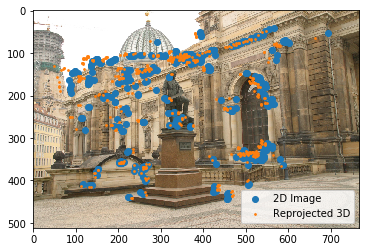

In [27]:
projPts2d2,_ = cv2.projectPoints(pts3dCorresp, R_final, t_final, K, None)

plt.imshow(images[2])
plt.scatter(pts2d21[:,0],pts2d21[:,1],label='2D Image')
plt.scatter(projPts2d2[:,0,0],projPts2d2[:,0,1],label='Reprojected 3D',s=3)
plt.legend();

That looks pretty bad doesn't it!

Luckily we can do much better with the following step...

#### Camera Pose Non-Linear Optimization

This time we complement with a non-linear least squares optimization, with a huber loss to help further with outliers, to minimize the reprojection loss: 
$$
\displaystyle
\hat{P} = \mathop{\arg\min}_{P} \sum_i \Vert \mathrm{Proj}(P,X_i^{\mathrm{3D}}) - x_i^{\mathrm{2D}} \Vert
$$

In [28]:
def calcResiduals(Rt):
    # TODO: Calculate the residuals given
    
    #     `Rt`: [r0, r1, r2, tx, ty, tz], 
    #     `pts3dCorresp`: the 3D points,
    #     `pts2d21`: the 2D matching points,
    #     `K`: the intrinsics matrix
    # e.g. `cv2.projectPoints(pts3dCorresp, ...)`
    # return the difference between the projected points and the 2D points (e.g. `(proj - pts2d21).ravel()`)
    proj, _ = cv2.projectPoints(pts3dCorresp, Rt[:3], Rt[3:], K, None)
    proj = np.array(proj).reshape(len(proj), 2)
    return (proj - pts2d21).ravel()
    
res = scipy.optimize.least_squares(calcResiduals, 
                                   np.hstack([cv2.Rodrigues(R_final)[0].T, t_final[np.newaxis]]).ravel(), 
                                   verbose=1,
                                   loss='huber')

`ftol` termination condition is satisfied.
Function evaluations 15, initial cost 8.1624e+03, final cost 2.7886e+03, first-order optimality 6.90e-02.


Get the optimized rotation and translation

In [29]:
R2 = cv2.Rodrigues(res.x[:3])[0]
t2 = res.x[3:]

Display the new projected points to verify the solution

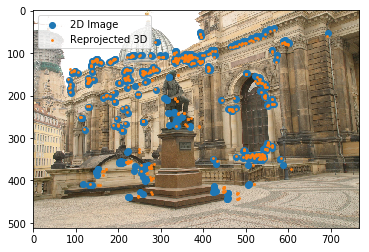

In [30]:
projPts2d2,_ = cv2.projectPoints(pts3dCorresp, R2, t2, K, None)

plt.imshow(images[2])
plt.scatter(pts2d21[:,0],pts2d21[:,1],label='2D Image')
plt.scatter(projPts2d2[:,0,0],projPts2d2[:,0,1],label='Reprojected 3D',s=3)
plt.legend();

Now that looks much better!

### Re-Triangulate with more views

Re-triangulate the existing points with more constraints

In [31]:
# gather all the aligned 2D points from the 3 views
# normalized 2D coordinates:
mpts0t_corresp = np.array([mpts01t[c[0]] for c in corresp12])
mpts1t_corresp = np.array([mpts10t[c[0]] for c in corresp12])
mpts2t_corresp = np.array([mpts21t[c[1]] for c in corresp12])
# original 2D coordinates:
mpts0f_corresp = np.array([mpts01f[c[0]] for c in corresp12])
mpts1f_corresp = np.array([mpts10f[c[0]] for c in corresp12])
mpts2f_corresp = np.array([mpts21f[c[1]] for c in corresp12])

In [32]:
pts2Dt_corresp = [mpts0t_corresp, mpts1t_corresp, mpts2t_corresp]
pts2Df_corresp = [mpts0f_corresp, mpts1f_corresp, mpts2f_corresp]
Rs_corresp     = [np.eye(3,3),    R_best, R2]
ts_corresp     = [np.zeros((3,)), t_best, t2]

In [33]:
# triangulate points
pts4d = triangulatePointsHomog(pts2Dt_corresp, Rs_corresp, ts_corresp).T
# undo homogeneous coordinate
pts3d = np.vstack([pts4d[0,:] / pts4d[3,:],pts4d[1,:] / pts4d[3,:],pts4d[2,:] / pts4d[3,:]]).T

Show the re-triangulated 3D points using all views

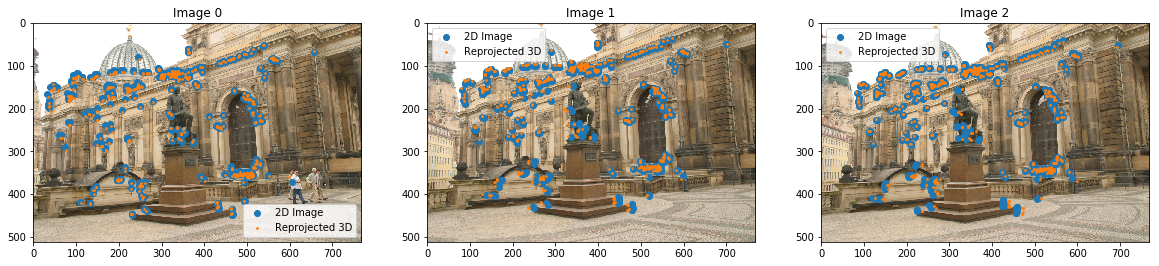

In [34]:
plt.figure(figsize=(20,5))
for i in [0,1,2]:
    plt.subplot(1,3,i+1)
    projPts2d_,_ = cv2.projectPoints(pts3d, Rs_corresp[i], ts_corresp[i], K, None)
    pts2D_ = pts2Df_corresp[i]
    plt.imshow(images[i])
    plt.scatter(pts2D_[:,0],pts2D_[:,1],label='2D Image')
    plt.scatter(projPts2d_[:,0,0],projPts2d_[:,0,1],label='Reprojected 3D',s=3)
    plt.title('Image %d'%i)
    plt.legend();

We can easily see many 3D points are not reprojecting exactly on their originating 2D counterparts. This can be dealt with in a non-linear least squares optimization, a.k.a Bundle Adjustment.

Inspect the 3D reconstruction so far from above:

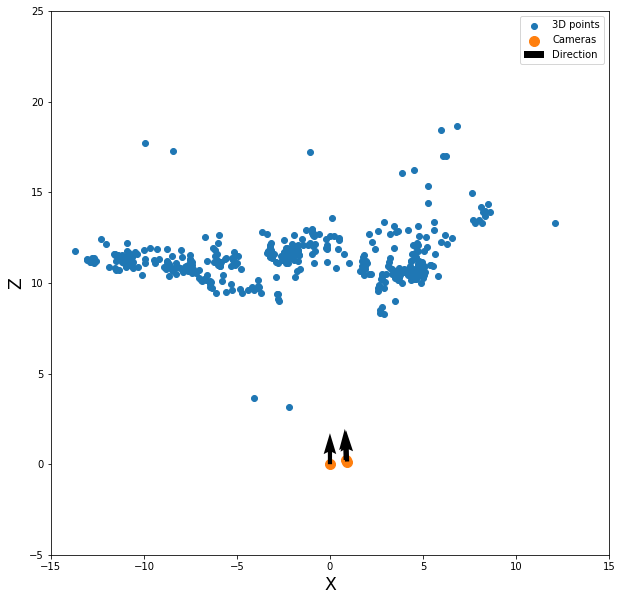

In [35]:
plt.figure(figsize=(10,10))
plt.scatter(pts3d[:,0],pts3d[:,2], label='3D points')
plt.scatter(np.array(ts_corresp)[:,0],np.array(ts_corresp)[:,2],s=100, label='Cameras')
plt.quiver(np.array(ts_corresp)[:,0],np.array(ts_corresp)[:,2],-np.array(Rs_corresp)[:,0,2],np.array(Rs_corresp)[:,0,0],label='Direction')
plt.xlabel('X', fontsize='xx-large'),plt.ylabel('Z', fontsize='xx-large')
plt.legend()
plt.xlim((-15,15)),plt.ylim((-5,25));

---
## 3. Bundle Adjustment

Write a bundle adjuster to optimize the reconstruction in Q.2: Find the optimal camera intrinsics, extrinsics (camera pose) and 3D points, such that the reprojection error is minimal:
$$
\hat{X}, \hat{C}, \hat{K} = \mathop{\arg\min}_{X,C,K} \sum_j^M \sum_i^N \left\Vert \mathrm{Proj}(X_i^\mathrm{(3D)},C_j,K) - x_i^\mathrm{(2D)} \right\Vert^2
$$

Assume:
1. All cameras have the same K matrix
2. Pixels are square ($f_x = f_y$)
3. There is no skew ($K_{0,1} = 0$)

Pack all the parameters for this reconstruction into a single (very long) vector like so:
$$
\left[R^0_{1\times3}, R^1_{1\times3}, R^2_{1\times3}, t^0_{1\times3}, t^1_{1\times3}, t^2_{1\times3}, f, c_x, c_y, p^{0}_{\mathrm{3D}},\dots,p^{N}_{\mathrm{3D}}\right]
$$
Rotation matrices $3\times3$ should be converted to Rodrigues formula $1\times3$ (`cv2.Rodrigues(...)[0]`).

In [36]:
# create the vector of parameters for initialization
n_cams = 3
n_pts = pts3d.shape[0]
params_size = n_cams * 6 + n_pts * 3 + 3

# vector of parameters
x0 = np.zeros((params_size,), np.float64)

# TODO: from [0, n_cams * 3] - put the Rotations from `Rs_corresp` (convert to Rodrigues with cv2.Rodrigues)
# TODO: from [n_cams * 3, n_cams * 6] - put the Translations from `Ts_corresp`
# TODO: from [n_cams * 6, n_cams * 6 + 3] - put f, cx, cy from `K`
# TODO: from [n_cams * 6 + 3, :] - put the 3D points from `pts3d`

l1=[]
l2=[]
l3=[]
l4=[]
rs0,_ = cv2.Rodrigues(Rs_corresp[0])
rs1,_ = cv2.Rodrigues(Rs_corresp[1])
rs2,_ = cv2.Rodrigues(Rs_corresp[2])
l1 = np.append(rs0.T, rs1.T)
l2 = np.append(l1, rs2.T)
x0[0:n_cams*3] = np.array(l2)
l3 = np.append(ts_corresp[0], ts_corresp[1])
l4 = np.append(l3, ts_corresp[2])
x0[n_cams*3:n_cams*6] = np.array(l4)

f = K[0][0]
cx = K[0][2]
cy = K[1][2]
initial = n_cams*6
x0[initial] = f
x0[initial + 1] = cx
x0[initial + 2] = cy
x0[n_cams*6 + 3:] = pts3d.ravel()



This following function calculates the residuals vector, e.g. $\left[\dots,r_{ji}^x,r_{ji}^y,\dots\right]$ where $r_{ji} = \left(\mathrm{Proj}(P^{\mathrm{3D}}_i,C_j,K)-p^{\mathrm{2D}}_i\right)$, unpacking the parameters for $P^{\mathrm{3D}}_i,C_j,K$ from the `params` vector, and taking the 2D point $p^{\mathrm{2D}}_i$ from the `pts2d` argument. The shape of the residuals vector is $1\times2N$, where $N$ is the number of points. 

In [37]:
def calcResidualsBA(params, n_cams, n_pts, pts2d, show_debug=False):
    Rs = params[:n_cams * 3].reshape((n_cams, 3))
    ts = params[n_cams * 3:n_cams * 6].reshape((n_cams, 3))
    f  = params[n_cams * 6:n_cams * 6+1]
    cx = params[n_cams * 6+1:n_cams * 6+2]
    cy = params[n_cams * 6+2:n_cams * 6+3]
    pts3d = params[n_cams * 6+3:].reshape((n_pts, 3))
    
    K_ = np.array([[f,0,cx],[0,f,cy],[0,0,1]], np.float32)
    
    resid = []
    for i in range(n_cams):
        # TODO: calculate the residuals, just like you did before, using `pts3d` and `pts2d[i]`
        # put the projected points in `projPts2d`, so the below debug view can work
        # ...
        projPts2d, _ = cv2.projectPoints(pts3d, Rs[i], ts[i], K_, None)
        projPts2dcpy = projPts2d
        projPts2dcpy = np.array(projPts2dcpy).reshape(n_pts, 2)
        resid[i*2*n_pts : i*2*n_pts + 2*n_pts] = (projPts2dcpy - pts2d[i]).ravel()
        if show_debug:
            plt.subplot(1,3,i+1)
            plt.imshow(images[i])
            plt.scatter(pts2d[i][:,0],pts2d[i][:,1],label='2D Image')
            plt.scatter(projPts2d[:,0,0],projPts2d[:,0,1],label='Reprojected 3D',s=3)
            plt.title('Image %d'%i)
            plt.legend();
        
    resid_combine = np.hstack(resid)
    return resid_combine

Check your residual calculation function works as expected:

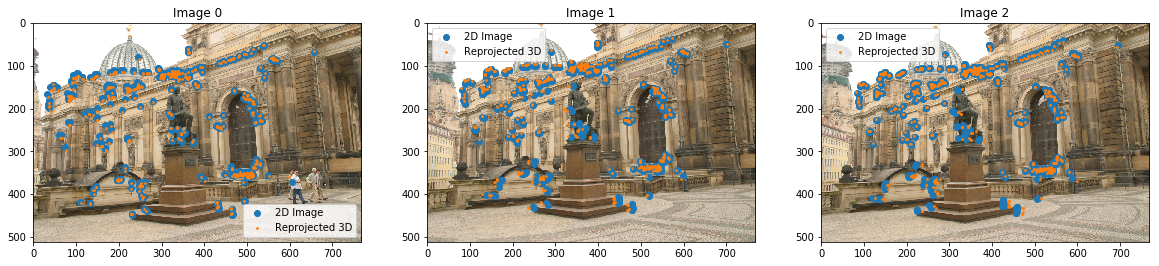

In [38]:
plt.figure(figsize=(20,5))
calcResidualsBA(x0, n_cams, n_pts, pts2Df_corresp, True);

This following function builds the sparsity matrix of the jacobian (partial derivative matrix), which greatly increases the speed of optimization. We let the optimizer calculate the jacobian by itself numerically (by adding small $\Delta$s to the parameters), which is a costly operation, therefore we guide it by saying what elements of the jacobian matrix will always be 0 and never have to be calculated. 

For each 2D point residual, many parameters for optimization in the system are irrelevant, and in fact a 2D residual is derived from just a handful of parameters: $K,C_j,P^{\mathrm{3D}}_i$, therefore the jacobian is very sparse. 

In [39]:
from scipy.sparse import lil_matrix

def bundle_adjustment_sparsity(n_cams, n_pts):
    global K_idx
    m = n_pts * n_cams * 2 # number of residuals
    n = n_cams * 6 + n_pts * 3 + 3 # number of parameters
    A = lil_matrix((m, n), dtype=int)
    
    ts_ids = n_cams * 3
    K_idx = ts_ids + n_cams * 3
    pts3d_idx = K_idx + 3

    # I'll save you the headache here...
    for j in range(n_cams):
        for i in range(n_pts):
            pt_res_idx = 2*i + j*n_pts*2
            A[pt_res_idx:pt_res_idx+2, j*3:j*3+3] = 1
            A[pt_res_idx:pt_res_idx+2, ts_ids+j*3:ts_ids+j*3+3] = 1
            A[pt_res_idx  , K_idx:K_idx+3] = [1,1,0]
            A[pt_res_idx+1, K_idx:K_idx+3] = [1,0,1]
            A[pt_res_idx:pt_res_idx+2, pts3d_idx+i*3:pts3d_idx+i*3+3] = 1

    return A

In [40]:
A = bundle_adjustment_sparsity(3, pts3d.shape[0])

To illustrate the sparsity of the jacobian:

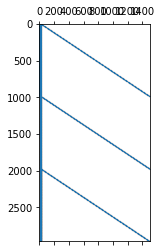

In [41]:
plt.spy(A,markersize=0.03);

Some parameters for optimization should be bound, and not be allowed to get extreme values. For example the focal length $f$ as well as $c_x,c_y$ cannot be negative, and $f$ should be capped above at e.g. 2000.

In [42]:
# set up bounds on the K (intrinsics parameters)
bounds = (np.full((params_size,),-np.inf),np.full((params_size,),np.inf))
bounds[0][K_idx:K_idx+3] = [100,0,0]
bounds[1][K_idx:K_idx+3] = [800,WIDTH,HEIGHT]

Run the NLLSQ optimizer:

In [43]:
res = scipy.optimize.least_squares(calcResidualsBA, x0, 
                                   jac_sparsity=A, 
                                   verbose=2, 
                                   x_scale='jac', 
                                   ftol=1e-5, 
                                   jac='3-point',
                                   bounds=bounds,
                                   args=(n_cams, n_pts, pts2Df_corresp))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6449e+04                                    4.80e+05    
       1              3         1.3421e+04      3.03e+03       5.70e+02       3.61e+05    
       2              4         6.4864e+03      6.93e+03       1.61e+02       4.91e+04    
       3              6         6.1159e+03      3.71e+02       6.68e+01       3.96e+04    
       4              8         5.9395e+03      1.76e+02       4.37e+01       5.65e+04    
       5              9         5.5313e+03      4.08e+02       6.86e+01       6.87e+04    
       6             10         5.3861e+03      1.45e+02       1.69e+02       2.08e+05    
       7             11         4.7264e+03      6.60e+02       1.18e+01       6.97e+03    
       8             12         4.6243e+03      1.02e+02       4.33e+01       2.82e+04    
       9             13         4.5346e+03      8.98e+01       8.81e+01       1.17e+05    

      90             98         3.3771e+03      5.29e-01       1.29e+00       2.17e+02    
      91             99         3.3769e+03      2.56e-01       1.51e+00       4.29e+02    
      92             100        3.3766e+03      2.70e-01       1.39e+00       2.23e+02    
      93             101        3.3763e+03      2.58e-01       1.39e+00       1.53e+02    
      94             102        3.3750e+03      1.35e+00       1.29e+01       1.15e+03    
      95             103        3.3736e+03      1.43e+00       2.25e+00       7.68e+02    
      96             104        3.3733e+03      2.78e-01       1.42e+00       1.97e+02    
      97             105        3.3726e+03      6.38e-01       5.03e+00       3.86e+02    
      98             106        3.3721e+03      5.03e-01       9.44e-01       3.68e+02    
      99             107        3.3719e+03      2.50e-01       1.82e+00       2.15e+02    
      100            108        3.3712e+03      6.91e-01       5.13e+00       1.49e+03    

      181            189        3.3426e+03      1.97e-01       1.59e+00       3.42e+02    
      182            190        3.3424e+03      1.81e-01       1.07e+00       2.18e+02    
      183            191        3.3424e+03      6.68e-02       2.47e-01       1.84e+02    
      184            192        3.3423e+03      4.23e-02       3.47e-01       1.23e+02    
      185            193        3.3422e+03      1.35e-01       1.36e+00       4.22e+02    
      186            194        3.3421e+03      9.90e-02       2.23e-01       8.40e+01    
      187            195        3.3419e+03      2.50e-01       3.15e+00       7.58e+02    
      188            196        3.3416e+03      2.32e-01       2.87e-01       1.42e+02    
      189            197        3.3415e+03      8.07e-02       1.00e+00       3.11e+02    
      190            198        3.3415e+03      8.72e-02       2.05e-01       8.44e+01    
      191            199        3.3411e+03      3.75e-01       4.89e+00       1.81e+03    

Lets have a look on the effect the optimization had on the residuals:

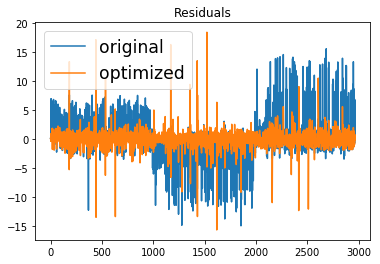

In [44]:
plt.plot(calcResidualsBA(x0, n_cams, n_pts, pts2Df_corresp),label='original')
plt.plot(calcResidualsBA(res.x, n_cams, n_pts, pts2Df_corresp),label='optimized')
plt.title('Residuals')
plt.legend(fontsize='xx-large');

Seems the residuals have mostly all improved.

Now visually on the images with the points projections:

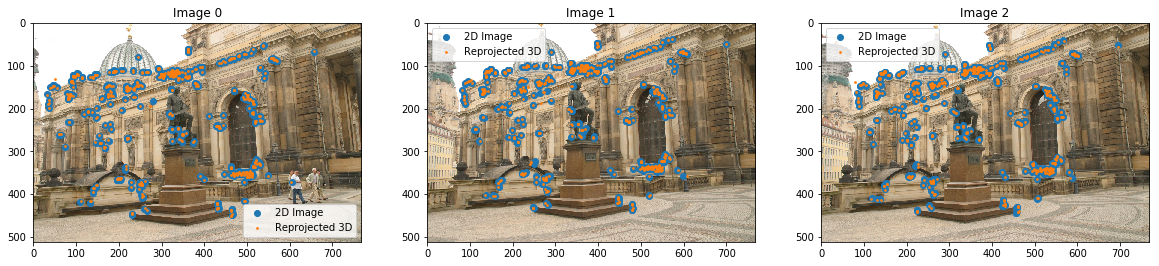

In [45]:
plt.figure(figsize=(20,5))
calcResidualsBA(res.x, n_cams, n_pts, pts2Df_corresp, True);

This looks much better than before, right? The reprojected 3D points land (mostly) exactly on the 2D measurements.

Collect the optimized measurements from the optimized parameters vector `res.x`:

In [50]:
# TODO ... , remember to reshape((n_cams, 3)), the Rs start at idx=0 in `res.x`
Rs_hat = res.x[:n_cams*3].reshape(n_cams, 3)
Rs_hat = -Rs_hat
# TODO ... , remember to reshape((n_cams, 3)), the Ts start at idx=(n_cams * 3) in `res.x`
ts_hat    = res.x[n_cams*3:n_cams*6].reshape(n_cams, 3)
# TODO ... , use `K_idx` for the index where f,cx,cy are in `res.x`
K_hat     = res.x[K_idx : K_idx + 3]
# TODO ... , remember to reshape((n_pts, 3))
pts3d_hat = res.x[n_cams*6+3:].reshape(n_pts, 3)

In [54]:
#Rs_hat    = # TODO ... , remember to reshape((n_cams, 3)), the Rs start at idx=0 in `res.x`
Rs_hat    =  res.x[: n_cams*3].reshape(n_cams, 3)
Rs_hat = -Rs_hat
#ts_hat    = # TODO ... , remember to reshape((n_cams, 3)), the Ts start at idx=(n_cams * 3) in `res.x`
ts_hat    = res.x[n_cams*3 : n_cams*6].reshape(n_cams, 3)

#K_hat     = # TODO ... , use `K_idx` for the index where f,cx,cy are in `res.x`
K_hat     =res.x[K_idx : K_idx+3]

#pts3d_hat = # TODO ... , remember to reshape((n_pts, 3))
pts3d_hat = res.x[n_cams*6+3:].reshape(n_pts, 3)

Show the 3D points (top-view, XZ plane):

((-6, 7), (1, 14))

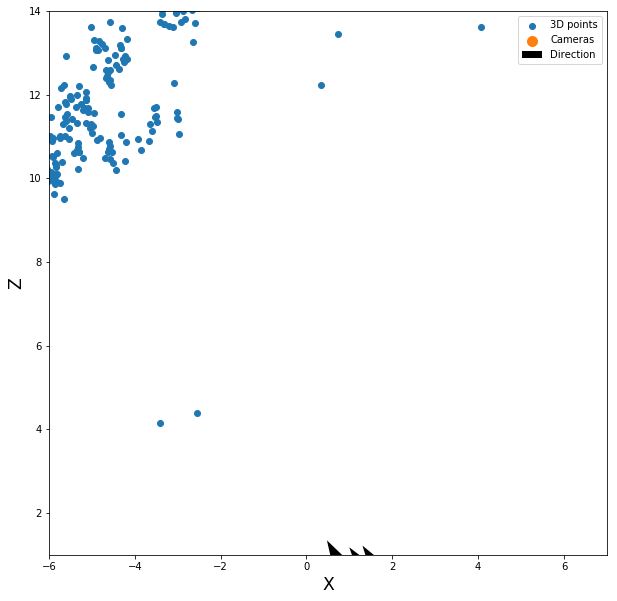

In [55]:
plt.figure(figsize=(10,10))
plt.scatter(pts3d_hat[:,0],pts3d_hat[:,2], label='3D points')
plt.scatter(ts_hat[:,0],ts_hat[:,2],s=100, label='Cameras')
plt.quiver(ts_hat[:,0],ts_hat[:,2],-Rs_hat[:,2],Rs_hat[:,0],label='Direction')
plt.xlabel('X', fontsize='xx-large'),plt.ylabel('Z', fontsize='xx-large')
plt.legend()
plt.xlim((-6,7)),plt.ylim((1,14))

---

That's a wrap!

Try increasing the amount of feature points you extract, and see if you can get a more dense reconstruction.

For the really adventerous of you, try to get a setero dense 3D reconsruction after rectifying the images for parallal motion. OpenCV offers `cv2.StereoBM` - a stereo matching algorithm for rectified views, which can calculate disparity based on parallel epipolar lines. You can get a full 3D model of the scene!